In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils import perspective
import cv2
import numpy as np
from pathlib import Path
import pydicom
import pandas as pd

# Reading the model to separate the teeth
model = tf.keras.models.load_model("UNET2FT9125CV1591919209.h5", compile=False)

In [2]:
img_size = (512, 512)
path = Path("data/")
df1 = pd.read_csv(path / "labels.csv")
df1.drop('Unnamed: 0', axis=1, inplace=True)

resized_images, labels = list(), list()
org_images = list()
masks_images = list()
mask_id = list()
mc = 0
for idx, (sop, lbl) in df1.iterrows():
    ds = pydicom.dcmread(path / f"DICOM/{sop}.dcm")    
    org_images.append(ds.pixel_array)
    resized_images.append(cv2.resize(ds.pixel_array, img_size) / 65536.)
    labels.append(1 if lbl == "abnormal" else 0)
    if lbl=="abnormal":
        masks_images.append(cv2.imread(str(path / f"masks/{sop}.png"), cv2.IMREAD_GRAYSCALE))
        mask_id.append(mc)
        mc+=1
    else:
        mask_id.append(0)

resized_images = np.array(resized_images)
labels = np.array(labels)
org_images = np.array(org_images)


C:\Users\HSH\AppData\Local\Temp\ipykernel_10244\2272898775.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  org_images = np.array(org_images)


In [3]:
def extract_teeth(teeth_name,orig_image,predict_image,pro_mask,image_label,erode_iteration,open_iteration):
    kernel1 =( np.ones((5,5), dtype=np.float32))
    kernel_sharpening = np.array([[-1,-1,-1], 
                                  [-1,9,-1], 
                                 [-1,-1,-1]])
    image = predict_image
    image2 =orig_image    
    image=cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel1,iterations=open_iteration )
    image = cv2.filter2D(image, -1, kernel_sharpening)
    image=cv2.erode(image,kernel1,iterations =erode_iteration)
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    labels=cv2.connectedComponents(thresh,connectivity=8)[1]       
    a=np.unique(labels)
    count2=0
    x_bor = 30
    y_bor = 50
    oiw = len(orig_image[0])
    oih = len(orig_image)
    tths_dic = {}
    for label in a:
        if label == 0:
            continue
    
        # Create a mask
        mask = np.zeros(thresh.shape, dtype="uint8")
        mask[labels == label] = 255
        # Find contours and determine contour area
        cnts,hieararch = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0]
        c_area = cv2.contourArea(cnts)
        # threshhold for tooth count
        if c_area>2000:
            count2+=1
        else:
            continue
        
        rect = cv2.minAreaRect(cnts)
        box = cv2.boxPoints(rect)
        box = np.array(box, dtype="int")    
        box = perspective.order_points(box)
        (tl,tr,br,bl)=box

        if tl[0]<oiw*0.1 or tr[0]>oiw*0.9 or bl[0]<oiw*0.1 or br[0]>oiw*0.9:
            continue
        if tl[1]<oih*0.1 or tr[1]<oih*0.1  or bl[1]>oih*0.9  or br[1]>oih*0.9:
            continue
        
        tth_id = teeth_name+'_'+str(label)

        ptl = [tl[0]-x_bor,tl[1]-y_bor]
        ptr = [tr[0]+x_bor,tr[1]-y_bor]
        pbl = [bl[0]-x_bor,bl[1]+y_bor]
        pbr = [br[0]+x_bor,br[1]+y_bor]
        pts_src = np.array([ptl,ptr,pbr,pbl])
        pts_dst = np.array([[0,0],[49,0],[49,99],[0,99]])

        h, status = cv2.findHomography(pts_src, pts_dst)
        img_out = cv2.warpPerspective(image2, h, (50,100))
        cv2.imwrite("teeths1/"+tth_id+'.png', img_out)

        y1 = int(min(tl[1],tr[1]))-y_bor
        y2 = int(max(bl[1],br[1]))+y_bor
        x1 = int(min(tl[0],bl[0]))-x_bor
        x2 = int(max(tr[0],br[0]))+x_bor
        img_out = image2[y1:y2 , x1:x2]
        img_out = cv2.resize(img_out,(50,100))
        cv2.imwrite("teeths2/"+tth_id+'.png', img_out)

        if image_label==0:
            tths_dic[tth_id] = 0
        else:
            tth_mask = pro_mask[y1:y2 , x1:x2]
            # print(label,tth_mask.mean())
            # plt.figure()
            # plt.imshow(tth_mask)
            # plt.title(tth_id)
            # plt.figure()
            # plt.imshow(img_out)
            # plt.title(tth_id)
            if tth_mask.mean()>70:
                cv2.imwrite("tths_masks/"+tth_id+'_mask.png', img_out)
                tths_dic[tth_id] = 1
            else:
                tths_dic[tth_id] = 0

    teeth_count=count2
    return teeth_count, tths_dic

In [5]:
import csv

ss = 10
num_image = len(labels)
teeths_ds = {}

for chk in range(84):      #int(num_image/ss)
    predicted_images = model.predict(resized_images[(chk*ss):(chk+1)*ss])
    for i in range(ss):
        img_inx = chk*ss+i
        org_img = org_images[img_inx]
        predicted = cv2.resize(predicted_images[i], (org_img.shape[1],org_img.shape[0]), interpolation=cv2.INTER_LANCZOS4)
        predicted *= 256
        _, predicted = cv2.threshold(predicted, thresh=255*0.8, maxval=255, type=cv2.THRESH_BINARY)
        mask = (masks_images[mask_id[img_inx]] if labels[img_inx]==1 else [])
        teeth_count,tths_ds=extract_teeth(str(img_inx),org_img,predicted.astype(np.uint8),mask,labels[img_inx],3,2)
        teeths_ds.update(tths_ds)

with open('teeths_labels.csv', 'w') as f:
    writer = csv.writer(f)
    for k in teeths_ds:
        writer.writerow([k,str(teeths_ds[k])])  

1/1 [==============================] - 31s 31s/step


1/1 [==============================] - 1s 1s/step
1 0.0
2 0.0
3 0.0
4 0.0
5 4.744979919678715
6 0.0
7 73.56009744880319
8 0.0
9 0.0
10 0.0
11 106.82994400235779
12 0.0
13 0.0


C:\Users\HSH\AppData\Local\Temp\ipykernel_3200\478837026.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


14 0.0
15 0.0
16 0.0
17 0.0
18 14.091964285714285
19 0.0
20 0.0
21 0.0
22 20.149660262417996
23 0.0
24 7.013418103902491


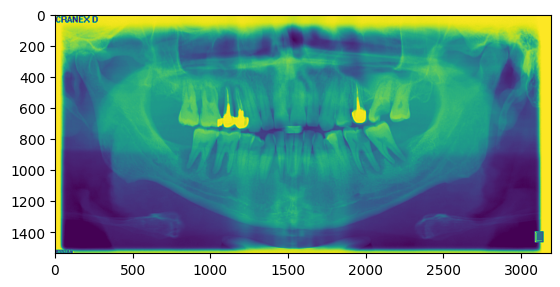

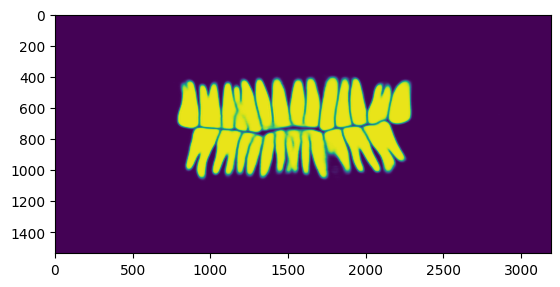

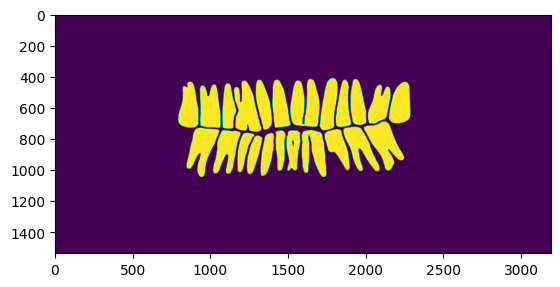

<Figure size 640x480 with 0 Axes>

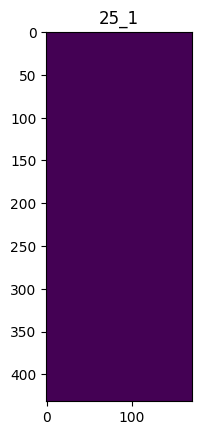

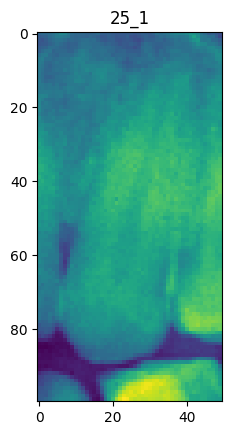

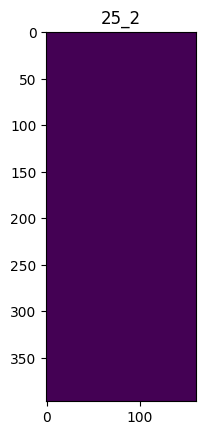

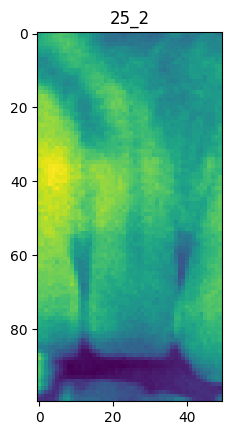

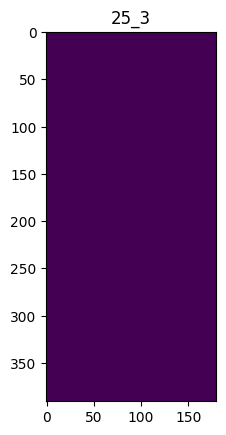

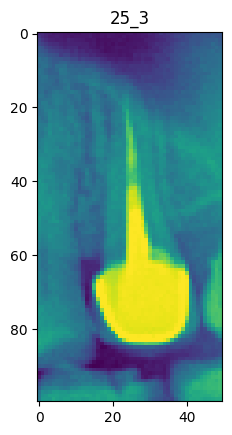

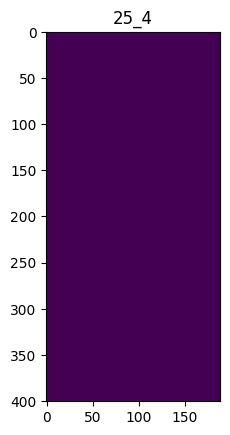

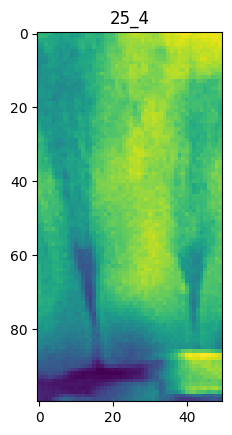

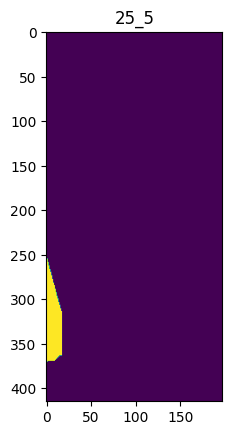

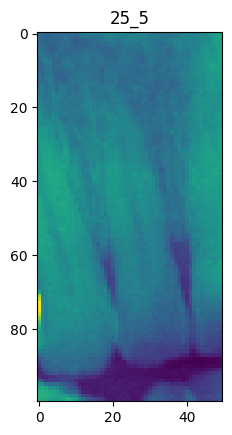

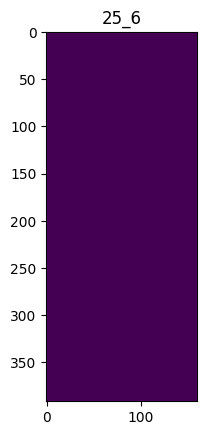

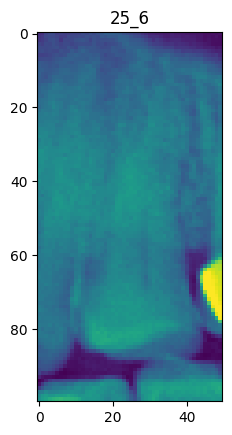

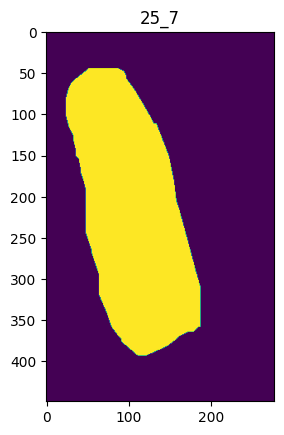

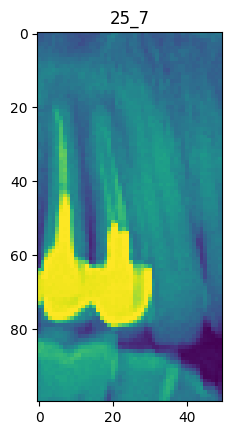

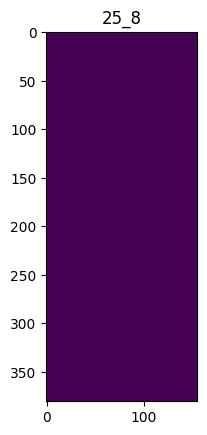

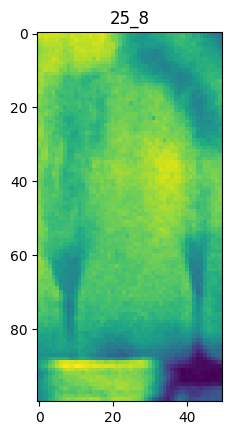

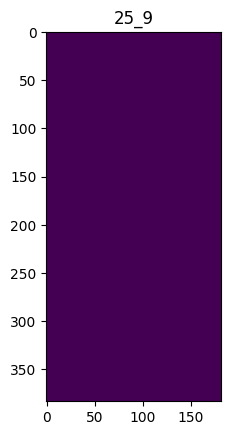

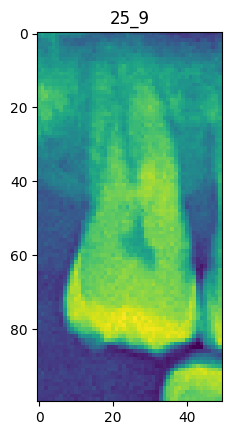

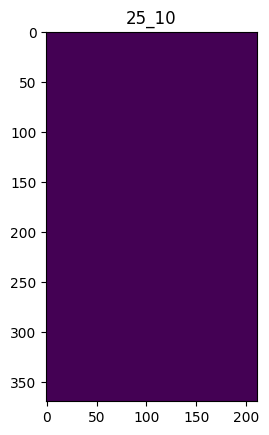

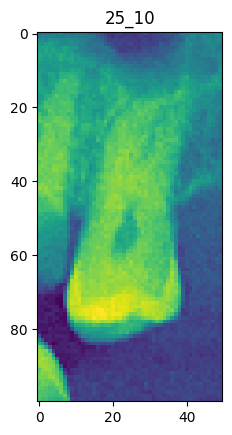

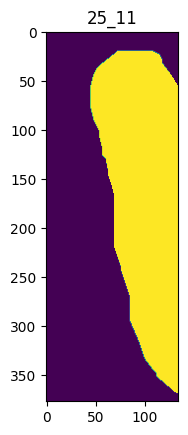

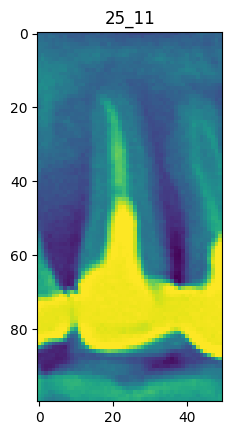

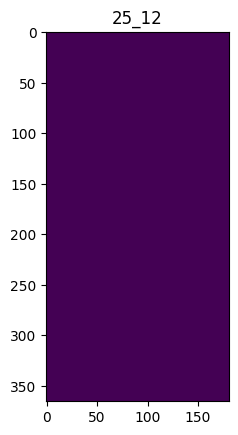

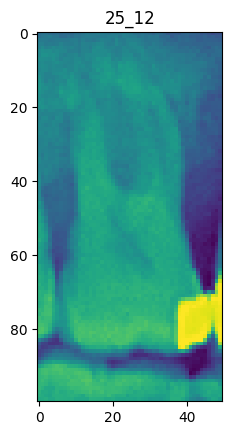

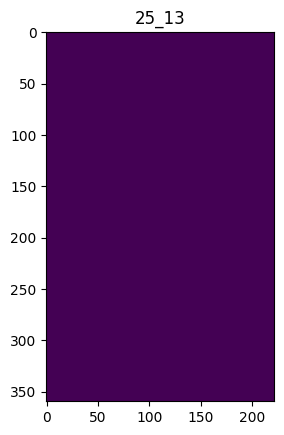

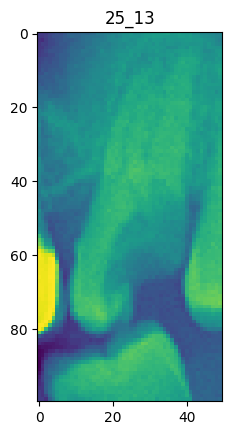

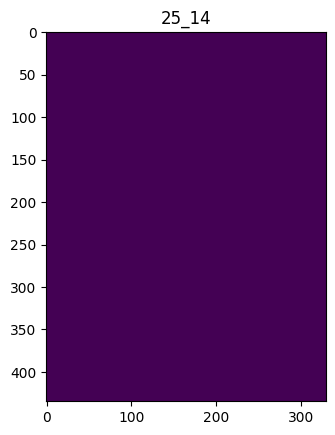

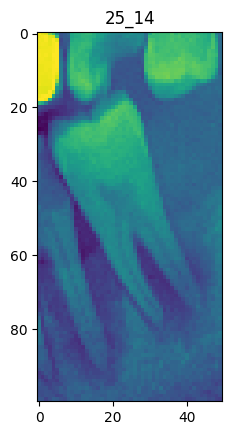

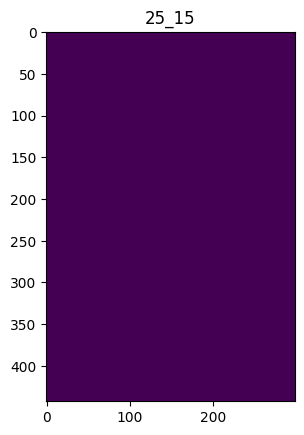

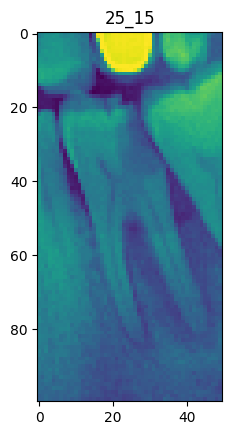

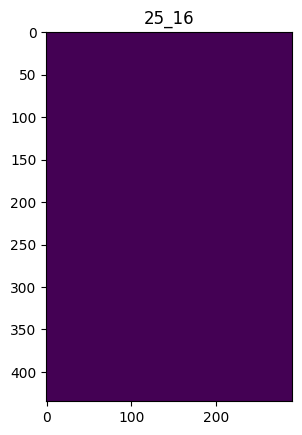

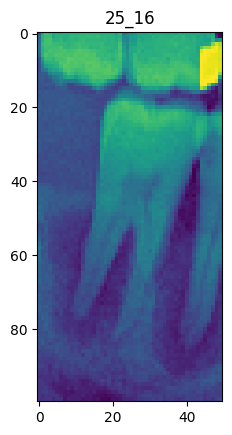

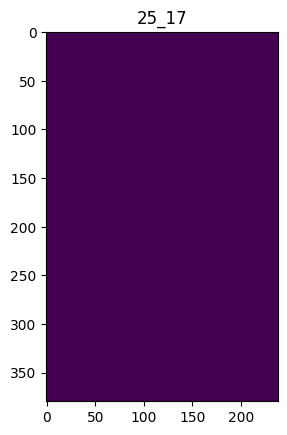

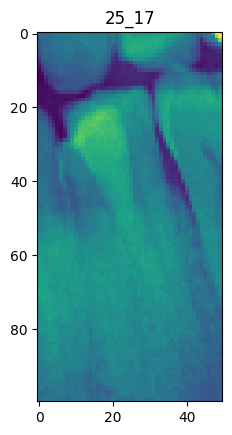

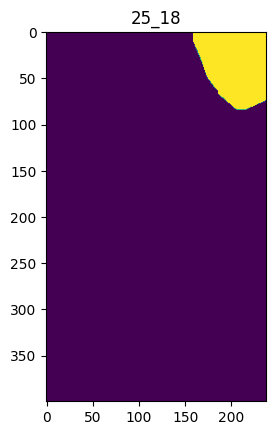

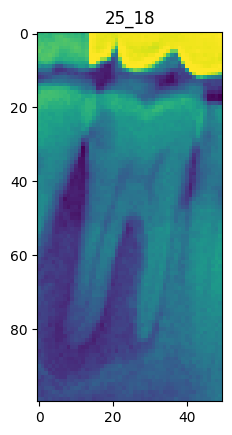

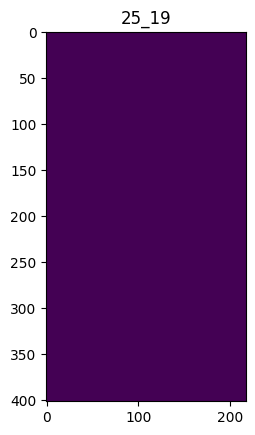

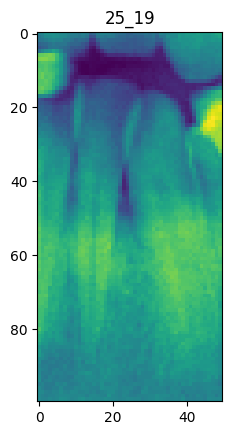

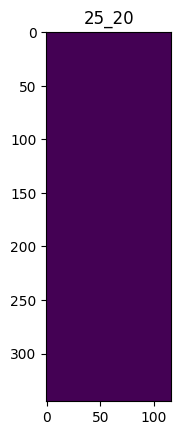

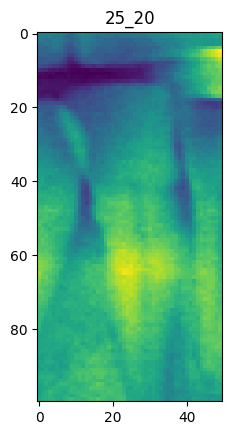

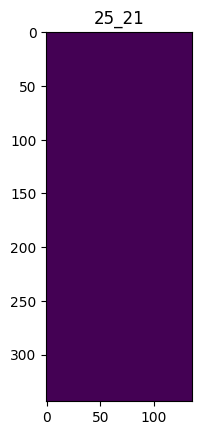

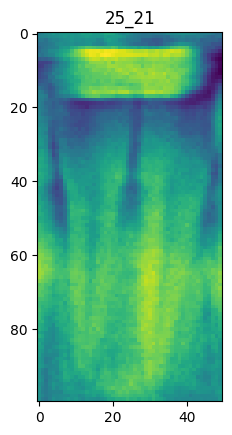

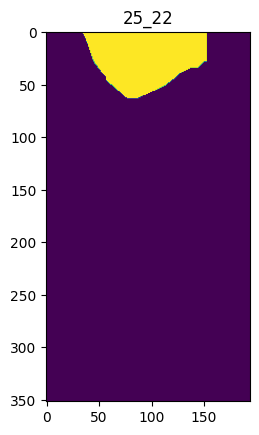

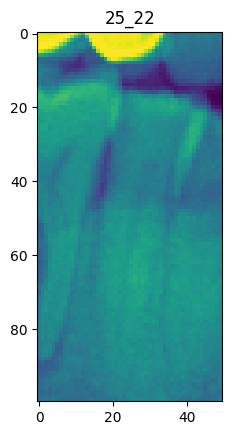

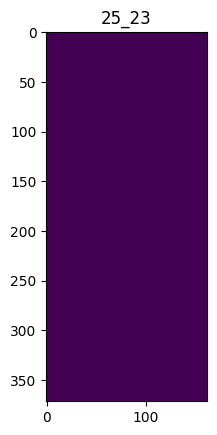

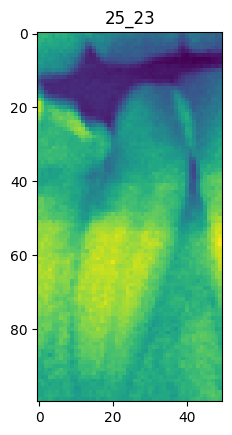

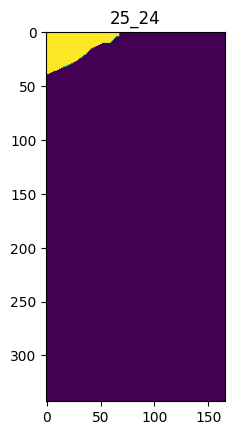

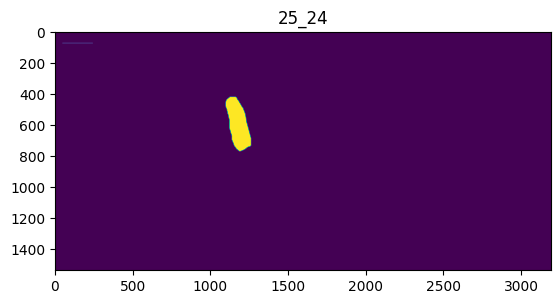

In [17]:
# Test Box

inx = 25
org_img = org_images[inx]
plt.imshow(org_img)
plt.figure()
imgList = list()
imgList.append(resized_images[inx])
predicted = model.predict(np.array(imgList))
predicted = predicted[0] 
predicted = cv2.resize(predicted, (org_img.shape[1],org_img.shape[0]), interpolation=cv2.INTER_LANCZOS4)
plt.imshow(predicted)
plt.figure()
predicted *= 256
_, predicted = cv2.threshold(predicted, thresh=255*0.8, maxval=255, type=cv2.THRESH_BINARY)
plt.imshow(predicted)
plt.figure()
mask = (masks_images[mask_id[inx]] if labels[inx]==1 else [])
teeth_count,tths_ds=extract_teeth(str(inx),org_img,predicted.astype(np.uint8),mask,labels[inx],3,2)
# print(teeth_count)
plt.imshow(mask)